In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import pandas_profiling
from matplotlib import style
%matplotlib inline
style.use('fivethirtyeight')

In [ ]:
!pip install  pandas_profiling update

In [33]:
data = pd.read_csv('/content/drive/MyDrive/Benkyou/datasets ML/Concrete_Data_Yeh.csv')
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [35]:
data.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


skewness check

In [36]:
data.skew()

cement              0.509481
slag                0.800717
flyash              0.537354
water               0.074628
superplasticizer    0.907203
coarseaggregate    -0.040220
fineaggregate      -0.253010
age                 3.269177
csMPa               0.416977
dtype: float64

In [37]:
class OutLierTreatment:
  def IQR(self,datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn,[5,95])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.5*iqr)
    upper_range = Q3 + (1.5*iqr)
    return round(lower_range,3),round(upper_range,3)
  def Treat(self,data):
    l,r = self.IQR(data)
    for i in range(len(data)):
      if data[i] > r:
        data[i] = r
      if  data[i] <l:
        data[i] =l
  
  def check(self,data):
    l,r=self.IQR(data)
    #print(l,r)
    j=0
    for i in data:
      if i<l or i>r:
        j=j+1
      return j


In [38]:

import math
import scipy.stats as ss

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go throug desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1.set(xlabel='Original ' + col)
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2.set(xlabel='Transformed ' + col)
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2.set(xlabel='NO TRANSFORM ' + col)
                plt.show()
                

    return DF


csMPa

 ------------------------------------------------------

 'cement' had 'positive' skewness of 0.51

 Transformation yielded skewness of -0.02


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



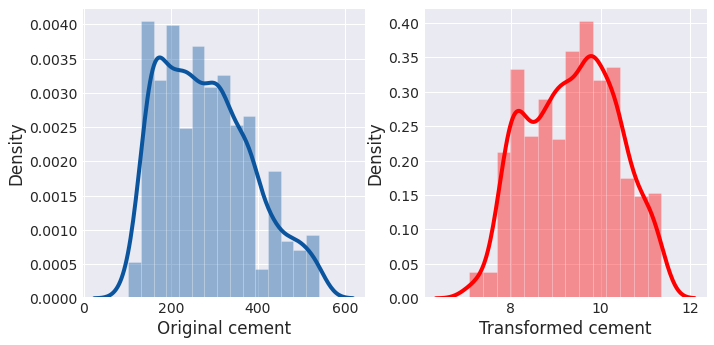

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 'slag' had 'positive' skewness of 0.80

 Transformation yielded skewness of -0.12


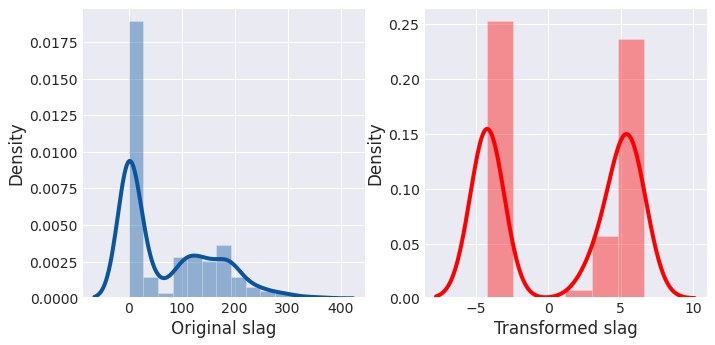

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 'flyash' had 'positive' skewness of 0.54

 Transformation yielded skewness of 0.20


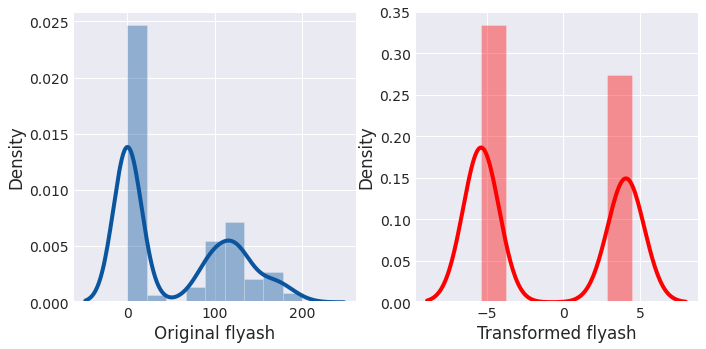

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'water' . Skewness = 0.07


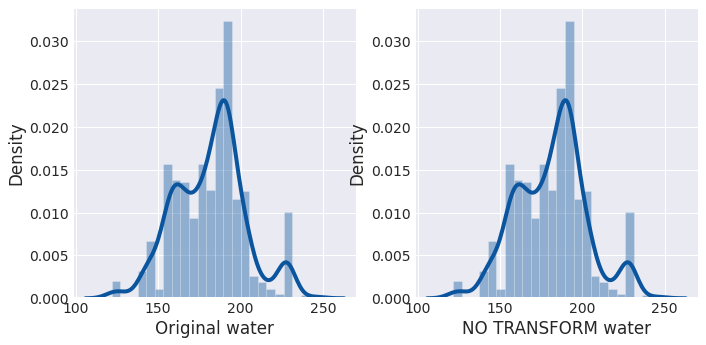

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 'superplasticizer' had 'positive' skewness of 0.91

 Transformation yielded skewness of -0.43


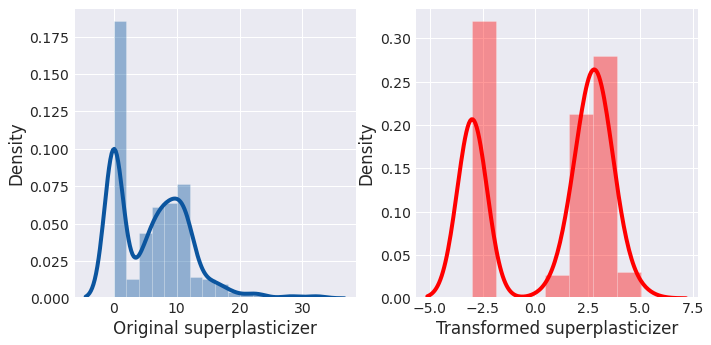

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'coarseaggregate' . Skewness = -0.04


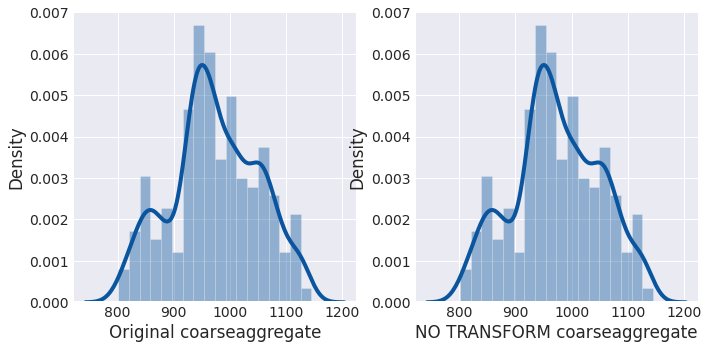

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'fineaggregate' . Skewness = -0.25


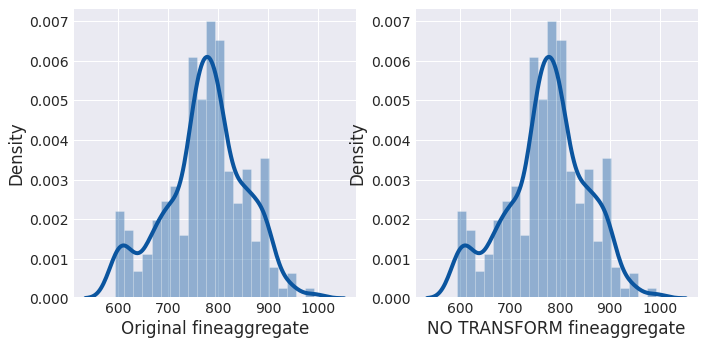

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 ------------------------------------------------------

 'age' had 'positive' skewness of 3.27

 Transformation yielded skewness of -0.01


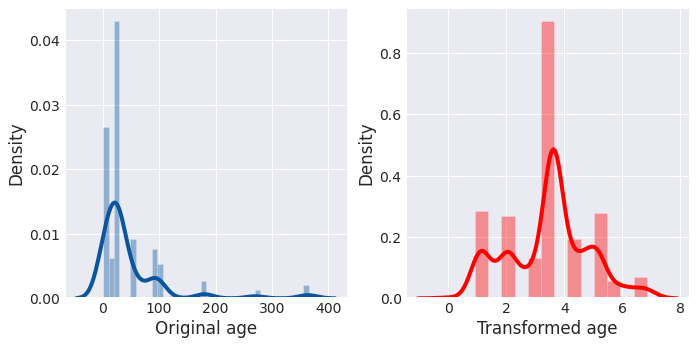

In [39]:
feature=data.columns.to_list()
target =feature.pop()
print(target)

df= skew_autotransform(data[feature].copy(deep=True),exclude=None,plot=True,threshold=0.5,exp=False)
df[target]= data[target]

In [40]:
df.skew()

cement             -0.019298
slag               -0.115598
flyash              0.203726
water               0.074628
superplasticizer   -0.430886
coarseaggregate    -0.040220
fineaggregate      -0.253010
age                -0.006074
csMPa               0.416977
dtype: float64

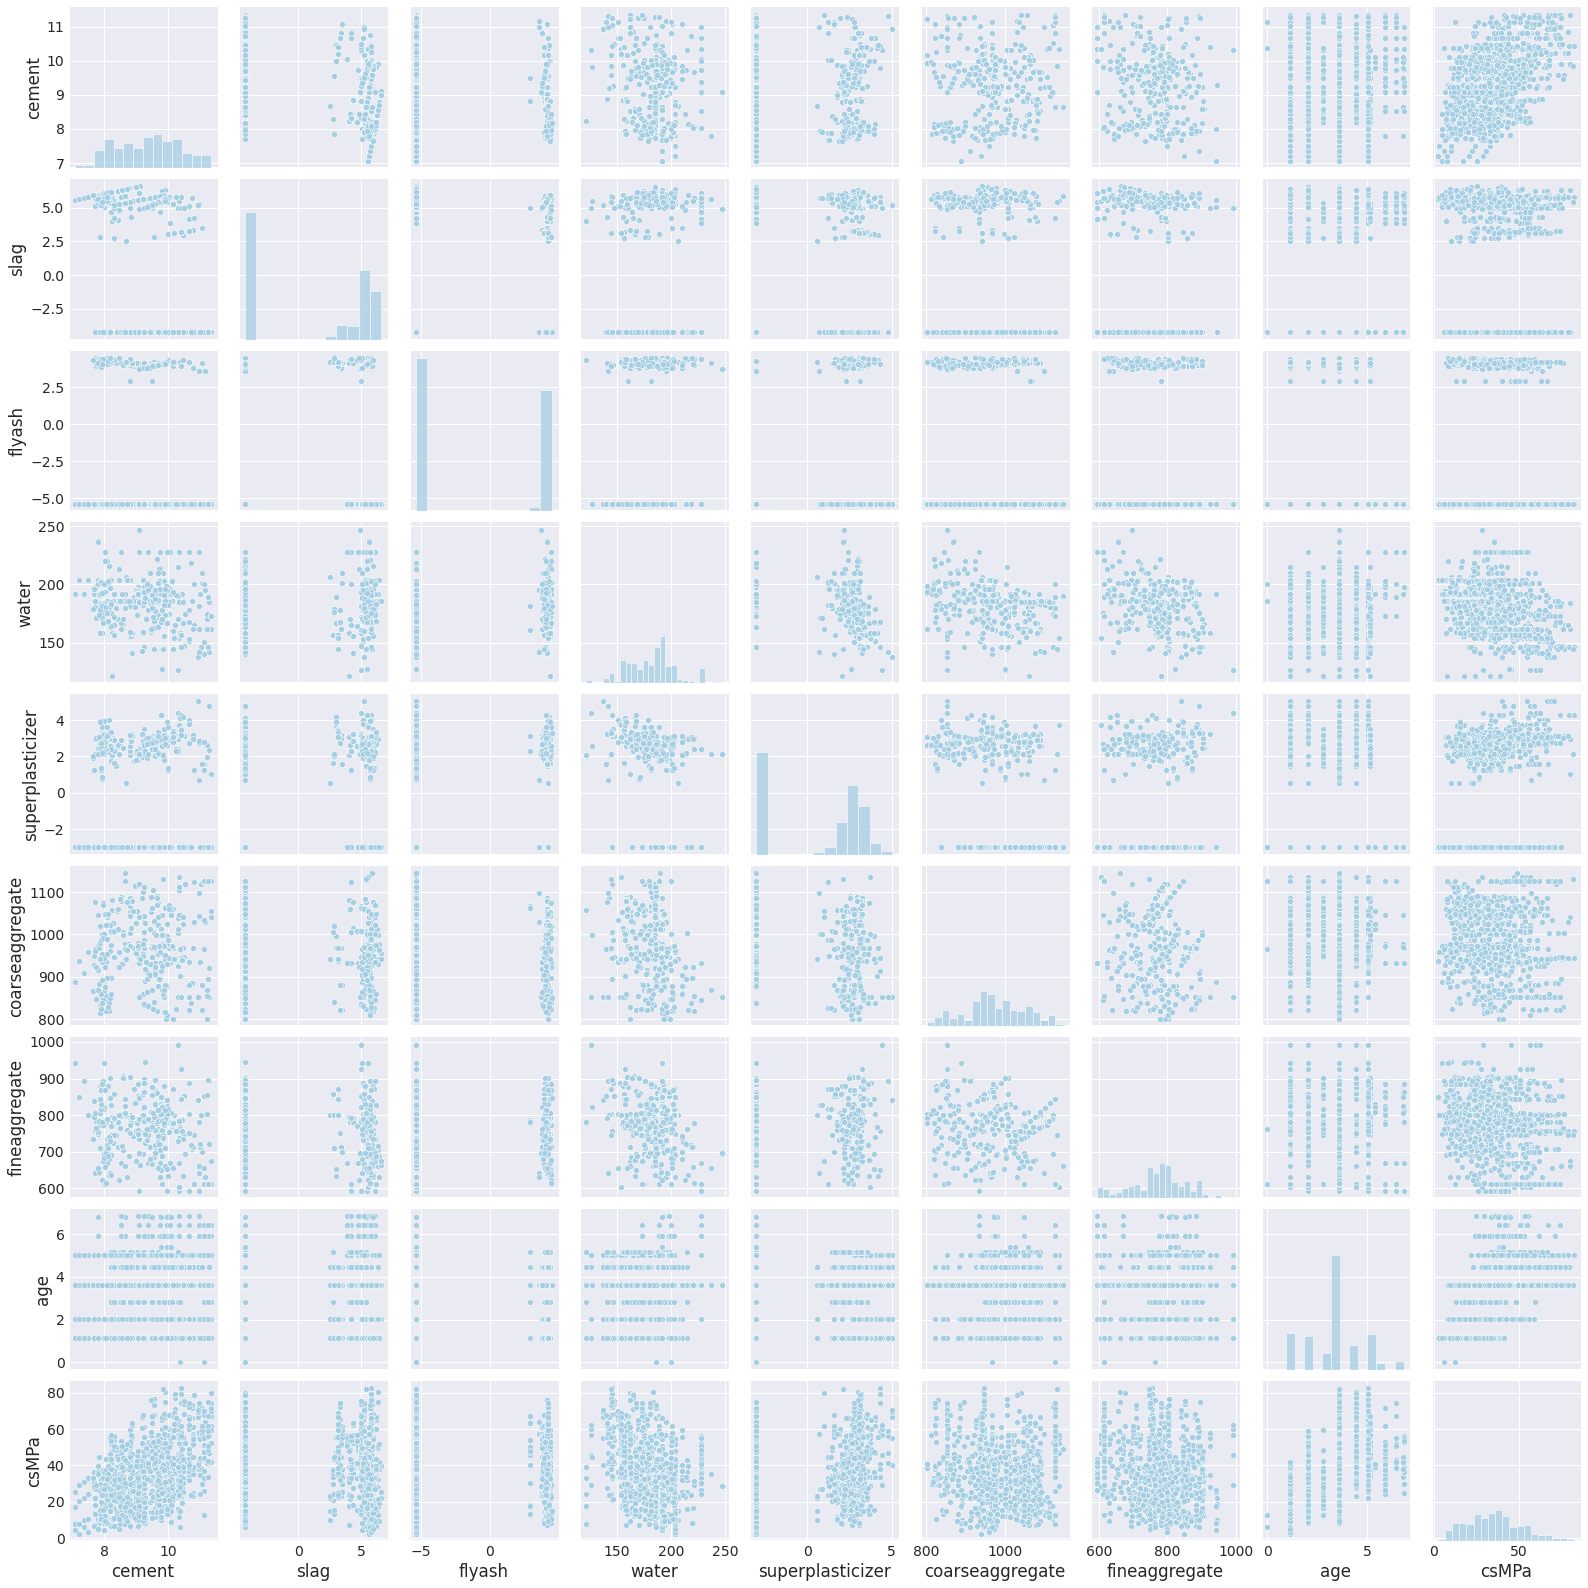

In [41]:
sns.pairplot(df)
plt.show()

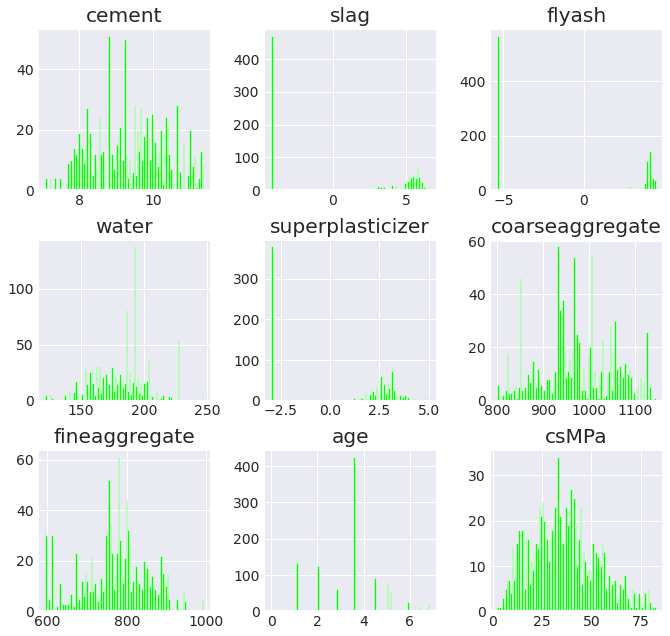

In [42]:
df.hist(bins=100,figsize=(10,10),color='lime')
plt.show()

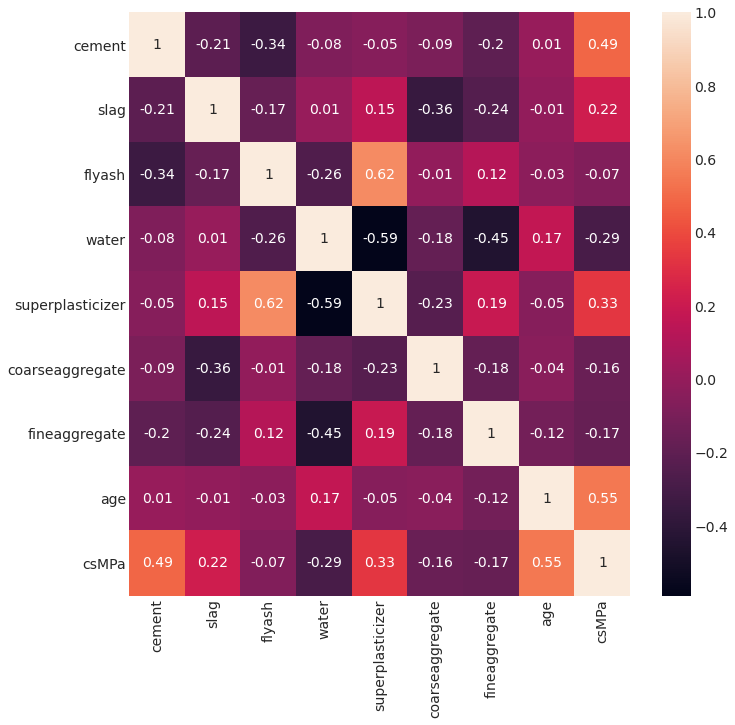

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr().round(2),annot =True)
plt.show()

In [44]:
def split_test_train(x,y,train_size =0.80,seed=None):
  np.random.seed(seed)
  y=np.array(y)
  data=np.concatenate([x,y.reshape(-1,1)],axis=1)
  np.random.shuffle(data)
  xtrain=data[:int(len(data)*train_size),:-1]
  ytrain=data[:int(len(data)*train_size),-1]
  xtest=data[int(len(data)*train_size):,:-1]
  ytest=data[int(len(data)*train_size):,-1]
  return xtrain,ytrain,xtest,ytest

In [54]:
x = df.drop(columns=target,inplace=False)
y = df[target]
xtrain,ytrain,xtest,ytest = split_test_train(x,y,train_size=0.80,seed=32)
print('Train data shapes \nx =',xtrain.shape,'y= ',ytrain.shape,'\nTest data shapes\nx =',xtest.shape,'y =',ytest.shape)

Train data shapes 
x = (824, 8) y=  (824,) 
Test data shapes
x = (206, 8) y = (206,)


In [55]:
from sklearn.linear_model import LinearRegression
lr =LinearRegression()

In [56]:
lr.fit(xtrain,ytrain)
ypred = lr.predict(xtest)

In [57]:
def mse(pred,true):
  return np.mean((true-pred)**2)

def rmse(pred,true):
  return np.sqrt(mse(pred,true))

def r_squared(true,pred):
    true_mean=true.mean()
    pred_mean=pred.mean()
    sst=((true-true_mean)**2).sum(axis=0)
    sse=((true-pred)**2).sum(axis=0)
    return 1-(sse/sst) #(sst-sse)/sst

In [ ]:
!pip install update sklearn.linear_model.SGDRegressor

In [80]:
from  sklearn.linear_model import SGDRegressor
gd = SGDRegressor(loss='squared_loss',alpha=0.00001)

In [81]:
gd.fit(xtrain,ytrain)

SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [82]:
pred_y = gd.predict(xtest)

In [83]:
Metrics = pd.DataFrame(data=[['Linear Regression',mse(ypred,ytest),rmse(ypred,ytest),r_squared(ypred,ytest)],['Gradient Descent',mse(pred_y,ytest),rmse(pred_y,ytest),r_squared(pred_y,ytest)]],columns=['Model','Mean Squared Error','Root Mean-sq Error','R**2 Error'])
Metrics

,Model,Mean Squared Error,Root Mean-sq Error,R**2 Error
0,Linear Regression,6.153146e+01,7.844199e+00,0.729499
1,Gradient Descent,1.013365e+28,1.006660e+14,-1.736080
